In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import math
from collections import Counter

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True 

In [3]:
class MultiLabelDualDataset(Dataset):
    def __init__(self, df, max_len=64):
        for col in ['full_text', 'full_text_phonetic', 'highlights', 'highlights_phonetic']:
            df[col] = df[col].fillna("")

        self.classes = sorted(df['figure_name'].unique())
        self.num_classes = len(self.classes)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        # Calculate Corpus Frequencies for TF-IDF (Rhetorical Weighting)
        all_words = " ".join(df['full_text'].astype(str)).lower().split()
        self.word_counts = Counter([w.strip('.,!?;:"()') for w in all_words])
        self.total_words = sum(self.word_counts.values())

        # Group Annotations by Instance
        self.grouped = df.groupby('full_text').agg({
            'full_text_phonetic': 'first',
            'figure_name': lambda x: list(set(x)),
            'highlights': lambda x: '; '.join(x.astype(str)),
            'highlights_phonetic': lambda x: '; '.join(x.astype(str))
        }).reset_index()

        self.max_len = max_len
        self.matrices_text = []
        self.matrices_phone = []
        self.multi_labels = []

        print(f"Generating Weighted Multi-Label Matrices for {len(self.grouped)} unique texts...")
        for _, row in self.grouped.iterrows():
            # These methods now use the weighting logic internally
            self.matrices_text.append(self.create_text_matrix(row['full_text']))
            self.matrices_phone.append(self.create_phone_matrix(row['full_text_phonetic']))
            
            # Create Binary Label Vector [0, 1, 0, 0, 1...]
            label_vec = np.zeros(self.num_classes, dtype=np.float32)
            for fig in row['figure_name']:
                label_vec[self.class_to_idx[fig]] = 1.0
            self.multi_labels.append(label_vec)

    # Simple IDF-style weighting: log(Total / Frequency)
    def get_word_weight(self, word):
        freq = self.word_counts.get(word, 1)
        # Normalize (Higher the weight, rarer the word)
        weight = math.log(self.total_words / freq)
        return min(1.0, weight / 10.0)

    def create_text_matrix(self, text):
        raw_words = str(text).lower().split()
        clean_words = [w.strip('.,!?;:"()') for w in raw_words]
        matrix = np.zeros((3, self.max_len, self.max_len), dtype=np.float32)
        
        for i in range(min(len(clean_words), self.max_len)):
            w1 = clean_words[i]
            # Calculate intrinsic importance of word i
            w1_weight = self.get_word_weight(w1) if len(w1) > 0 else 0
            
            for j in range(min(len(clean_words), self.max_len)):
                if i == j: continue
                w2 = clean_words[j]
                
                # Channel 0: Weighted Identity 
                if w1 == w2 and len(w1) > 0:
                    # Instead of 1.0, use the rhetorical weight
                    matrix[0, i, j] = w1_weight 
                
                # Channel 1: Weighted First Letter
                if w1[:1] == w2[:1] and len(w1) > 0:
                    matrix[1, i, j] = 0.5 * w1_weight
                    
                # Channel 2: Punctuation
                if any(p in raw_words[i] for p in [',', ';', ':']): 
                    matrix[2, i, j] = 1.0
        return matrix

    def create_phone_matrix(self, phonetic_text):
        # <W> is the word separator
        raw_phn_words = str(phonetic_text).split(' <W> ')
        matrix = np.zeros((2, self.max_len, self.max_len), dtype=np.float32)

        for i in range(min(len(raw_phn_words), self.max_len)):
            p1 = raw_phn_words[i].strip()
            if not p1: continue

            p1_weight = self.get_word_weight(p1) 

            for j in range(min(len(raw_phn_words), self.max_len)):
                if i == j: continue
                p2 = raw_phn_words[j].strip()
                if not p2: continue

                # Channel 0: Weighted Phonetic Identity
                if p1 == p2:
                    matrix[0, i, j] = p1_weight
                
                # Channel 1: Weighted Rhyme/Suffix
                if len(p1) > 3 and len(p2) > 3 and p1[-3:] == p2[-3:]:
                    matrix[1, i, j] = 0.5 * p1_weight
                    
        return matrix

    def __len__(self): return len(self.grouped)
    def __getitem__(self, idx):
        return (torch.tensor(self.matrices_text[idx]), 
                torch.tensor(self.matrices_phone[idx]), 
                torch.tensor(self.multi_labels[idx]))

In [4]:
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, 1, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        weights = self.sigmoid(self.conv(x))
        return x * weights

class StreamEncoder(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SpatialAttention(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
    def forward(self, x): return self.conv(x)

In [5]:
class DualStreamCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.text_encoder = StreamEncoder(3)
        self.phone_encoder = StreamEncoder(2)
        self.flatten = nn.Flatten()
        
        self.stream_weights = nn.Parameter(torch.ones(num_classes, 2)) 
        
        self.fc_shared = nn.Linear(1024, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.output_layer = nn.Linear(512, num_classes)

    def forward(self, txt, phn):
        t_feat = self.flatten(self.text_encoder(txt))
        p_feat = self.flatten(self.phone_encoder(phn))
        
        # Apply Gating Logic
        gates = torch.sigmoid(self.stream_weights) 
        
        logits = []
        for i in range(self.output_layer.out_features):
            combined_stream = (gates[i, 0] * t_feat) + (gates[i, 1] * p_feat)

            x = self.fc_shared(combined_stream)
            x = self.relu(x)
            x = self.dropout(x)
            class_logit = self.output_layer.weight[i] @ x.t() + self.output_layer.bias[i]
            logits.append(class_logit)
            
        return torch.stack(logits, dim=1)

## Training and evaluation

Rhetorical figures are not mutually exclusive. A single sentence can simultaneously exhibit phonetic patterns (like alliteration) and structural patterns (like anaphora). This function implements a specialized pipeline to handle this complexity through two distinct phases:
* **Dual-Stream Feature Fusion**: The model listens and reads simultaneously. By using `BCEWithLogitsLoss` (Binary Cross Entropy), we treat each rhetorical figure as an independent binary classification task, allowing the model to predict multiple figures for one input rather than forcing a single choice.

* **Decoupled Multi-Label Thresholding**: Rhetorical figures have varying signatures and frequencies. Rare figures (like Epizeuxis) may produce lower raw confidence scores than common ones (like Ploke). By iterating through potential thresholds ($0.05$ to $0.5$) and maximizing the F1-Score, we find the optimal sensitivity level for each specific figure.

* **Phonological vs. Structural Sensitivity**: The gradient descent phase allows the `DualStreamCNN` to learn that some figures rely heavily on the Text Stream (e.g., Antimetabole), while others rely on the Phonetic Stream (e.g., Assonance). This ensures the model understands the sound of the rhetoric along with the structure.

* **In-Process Hyperparameter Tuning**: Integrating threshold optimization directly after training ensures that the best_thresholds are tailored to the specific weights of the current model state. Saving these thresholds alongside the `model_state_dict` is critical for reproducible inference.

In [32]:
def train_and_tune(dataset, train_loader, test_loader, epochs=100):
    model = DualStreamCNN(dataset.num_classes).to(device)

    # This forces the model to work harder to prove a structural figure exists
    struct_figs = ["anadiplosis", "antimetabole", "epanalepsis", "epanaphora", "epiphora", "mesodiplosis"]
    struct_idx = [dataset.class_to_idx[f] for f in struct_figs if f in dataset.class_to_idx]
    
    with torch.no_grad():
        for idx in struct_idx:
            model.output_layer.bias[idx] -= 2.0  # Start with a negative bias

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.ones([dataset.num_classes]).to(device) * 0.8)
    class_names = dataset.classes

    print(f"Phase 1: Training with Directional Suppression for {epochs} epochs...")
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for txt, phn, labs in train_loader:
            txt, phn, labs = txt.to(device), phn.to(device), labs.to(device)
            optimizer.zero_grad()
            
            outputs = model(txt, phn)
            base_loss = criterion(outputs, labs)

            # DIRECTIONAL SUPPRESSION:
            # We want structural phonetic weights to be NEGATIVE (e.g., -4.0)
            # -4.0 in a sigmoid results in a gate value of ~0.018 (nearly off)
            target_floor = -4.0
            struct_phone_weights = model.stream_weights[struct_idx, 1]
            
            # This loss only triggers if the weight is HIGHER than -4.0
            suppression_loss = torch.mean(torch.relu(struct_phone_weights - target_floor))

            # Penalty 2.0: Still use a small norm to keep weights from exploding
            norm_penalty = 0.01 * torch.norm(model.stream_weights)

            loss = base_loss + (1.0 * suppression_loss) + norm_penalty
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        if (epoch+1) % 10 == 0:
            print(f"Epoch {epoch+1} | Loss: {total_loss/len(train_loader):.4f}")

    # Threshold Optimization
    print("\nPhase 2: Optimizing thresholds...")
    model.eval()
    all_outputs, all_labels = [], []
    with torch.no_grad():
        for txt, phn, labs in test_loader:
            txt, phn, labs = txt.to(device), phn.to(device), labs.to(device)
            all_outputs.extend(torch.sigmoid(model(txt, phn)).cpu().numpy())
            all_labels.extend(labs.cpu().numpy())

    all_outputs, all_labels = np.array(all_outputs), np.array(all_labels)
    best_thresholds = []
    
    for i in range(len(class_names)):
        best_f1, best_thresh = 0, 0.5
        # Search a wider range (up to 0.8) to filter out high-confidence hallucinations
        for thresh in np.linspace(0.05, 0.8, 30):
            preds = (all_outputs[:, i] > thresh).astype(float)
            f1 = f1_score(all_labels[:, i], preds, zero_division=0)
            if f1 > best_f1:
                best_f1, best_thresh = f1, thresh
        best_thresholds.append(best_thresh)
        print(f"Optimized {class_names[i]:<15} | Threshold: {best_thresh:.2f} | F1: {best_f1:.4f}")

    # Save logic remains the same...
    return model, best_thresholds, all_outputs, all_labels

This is a function that plots the confusion matrix of each figure. This diagnostic tool is vital for multi-label rhetorical analysis, as it reveals which specific figures are being successfully captured and which require further data augmentation due to high False Negative rates

In [33]:
def plot_multilabel_cm(labels, preds, class_names):
    mcm = multilabel_confusion_matrix(labels, preds)
    fig, axes = plt.subplots(int(np.ceil(len(class_names)/4)), 4, figsize=(16, 10))
    axes = axes.ravel()
    for i, name in enumerate(class_names):
        sns.heatmap(mcm[i], annot=True, fmt='d', ax=axes[i], cmap='Greens', cbar=False)
        axes[i].set_title(name)
    plt.tight_layout()
    plt.show()

This function performs an end-to-end audit of the model's rhetorical intelligence by analyzing three specific layers of performance:

* **Holistic Inference**: It runs a fresh pass of the `test_loader` through the model in `eval()` mode. This ensures the metrics reflect the model's final frozen state.

* **Precision/Recall Calibration**: By applying the class-specific `best_thresholds`, it generates a Classification Report. This allows us to see the F1-Score for each figure individually, and helps identify which rhetorical devices the model has mastered and which ones it finds ambiguous.

* **Inter-Figure Relationship Mapping**: It calculates a Normalized Co-occurrence Matrix. This visualizes linguistic overlapping, for example, if the model correctly understands that a Rhyme almost always co-occurs with Consonance.

* **Error Distribution Analysis**: By calling `plot_multilabel_cm`, it reveals the exact ratio of hallucinations (False Positives) to missed catches (False Negatives) for every rhetorical category.

In [34]:
def run_diagnostics(model, test_loader, best_thresholds, class_names):
    model.eval()
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for txt, phn, labs in test_loader:
            txt, phn = txt.to(device), phn.to(device)
            output = torch.sigmoid(model(txt, phn))
            all_outputs.extend(output.cpu().numpy())
            all_labels.extend(labs.cpu().numpy())

    all_outputs = np.array(all_outputs)
    all_labels = np.array(all_labels)
    
    final_preds = (all_outputs > np.array(best_thresholds)).astype(float)

    print("\nFinal Multi-Label Classification Report:")
    print(classification_report(all_labels, final_preds, target_names=class_names))

    # Confusion Matrices
    plot_multilabel_cm(all_labels, final_preds, class_names)

    # Co-occurrence Matrix
    co_matrix = np.dot(final_preds.T, final_preds)
    diag = np.diagonal(co_matrix)
    with np.errstate(divide='ignore', invalid='ignore'):
        co_matrix_norm = np.nan_to_num(co_matrix / diag[:, None])
    
    plt.figure(figsize=(14, 12))
    sns.heatmap(co_matrix_norm, annot=True, fmt='.2f', cmap='YlGnBu',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Rhetorical Figure Co-occurrence (Normalized)')
    plt.tight_layout()
    plt.show()
    
    return all_labels, final_preds

Generating Weighted Multi-Label Matrices for 3111 unique texts...
Phase 1: Training with Directional Suppression for 100 epochs...
Epoch 10 | Loss: 4.6341
Epoch 20 | Loss: 3.8441
Epoch 30 | Loss: 3.0773
Epoch 40 | Loss: 2.3051
Epoch 50 | Loss: 1.5281
Epoch 60 | Loss: 0.7484
Epoch 70 | Loss: 0.3505
Epoch 80 | Loss: 0.3289
Epoch 90 | Loss: 0.3138
Epoch 100 | Loss: 0.3020

Phase 2: Optimizing thresholds...
Optimized alliteration    | Threshold: 0.15 | F1: 0.5158
Optimized anadiplosis     | Threshold: 0.26 | F1: 0.5547
Optimized antimetabole    | Threshold: 0.10 | F1: 0.5533
Optimized assonance       | Threshold: 0.05 | F1: 0.2062
Optimized consonance      | Threshold: 0.15 | F1: 0.2675
Optimized epanalepsis     | Threshold: 0.10 | F1: 0.3134
Optimized epanaphora      | Threshold: 0.31 | F1: 0.6405
Optimized epiphora        | Threshold: 0.21 | F1: 0.3645
Optimized epizeuxis       | Threshold: 0.21 | F1: 0.5000
Optimized mesodiplosis    | Threshold: 0.28 | F1: 0.6173
Optimized ploke        

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


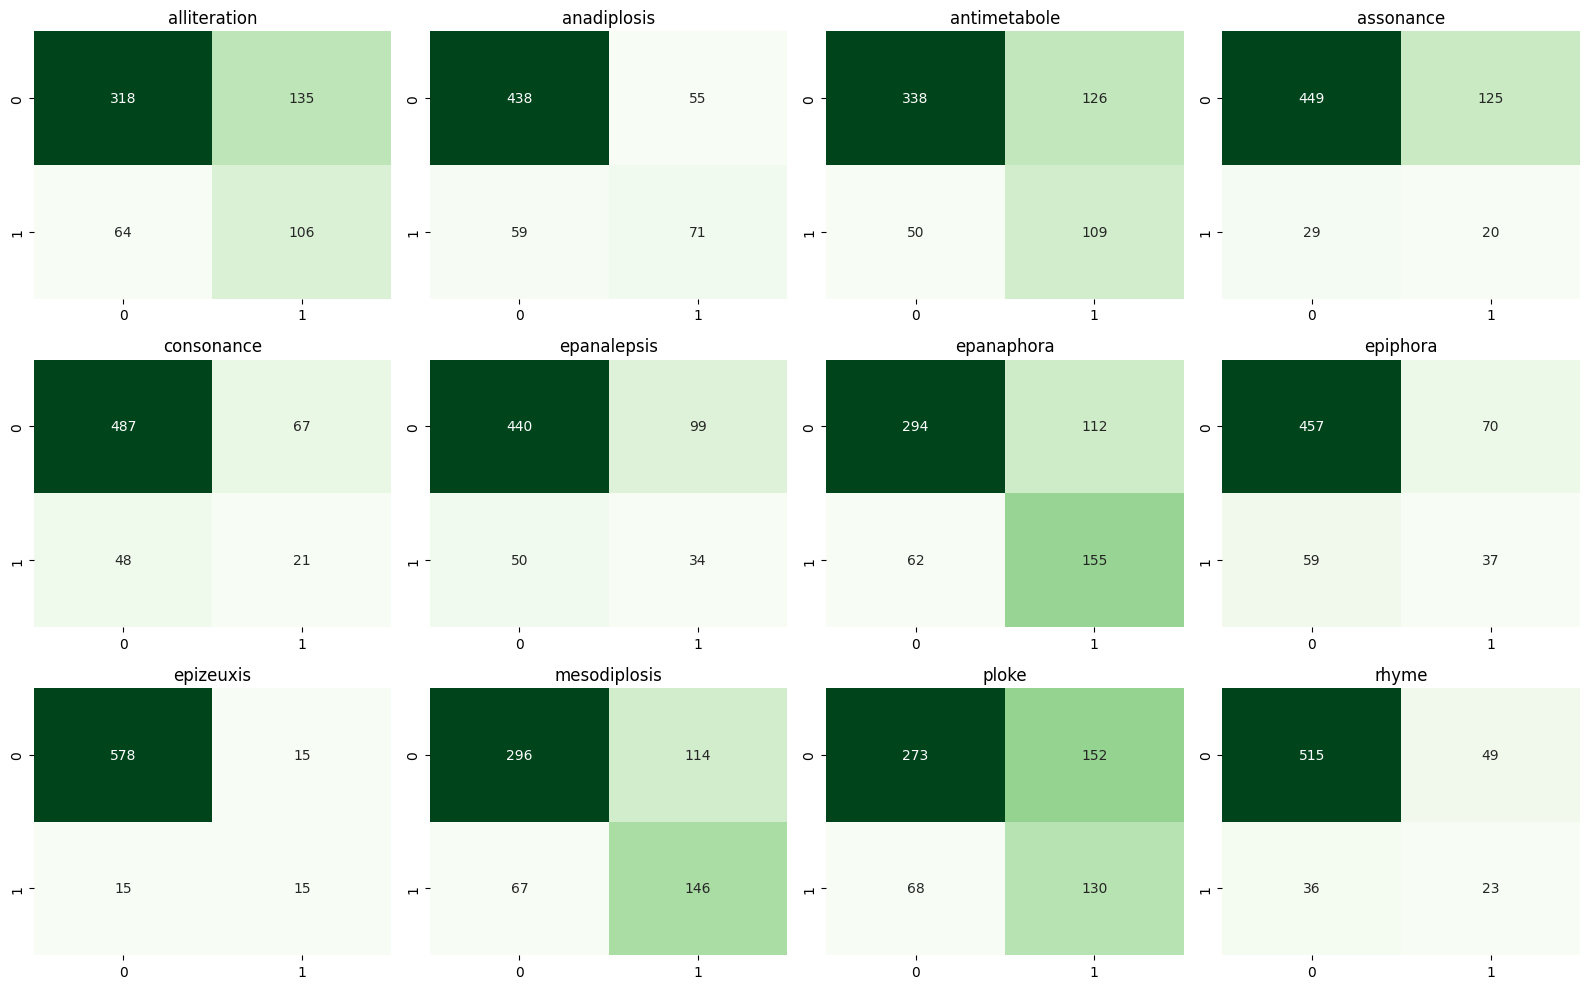

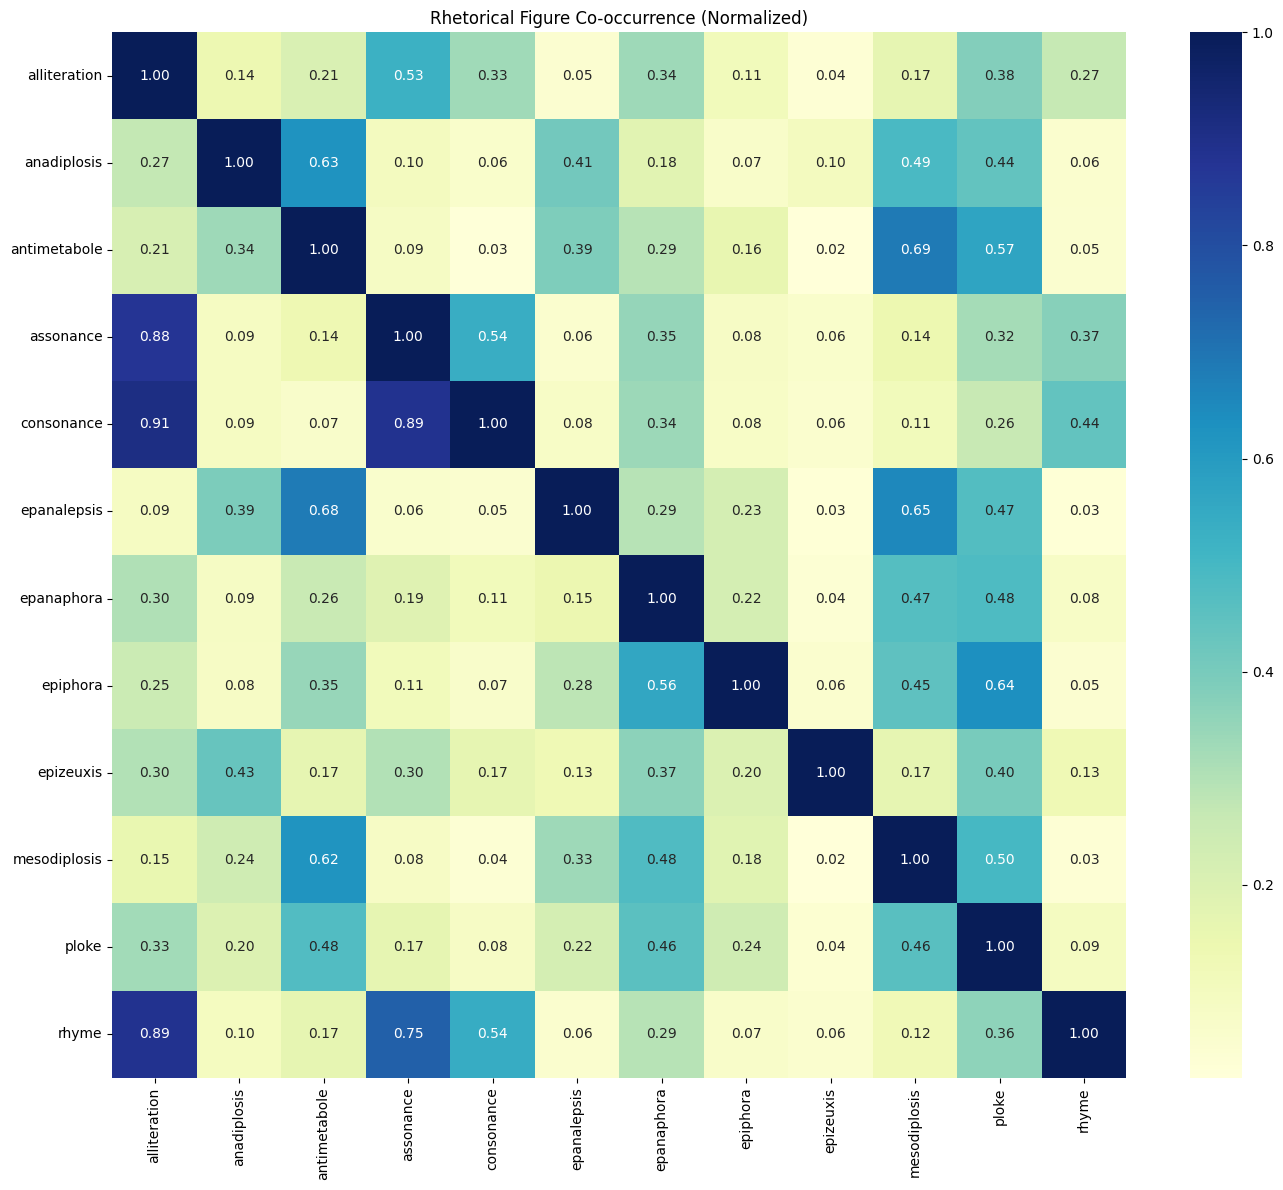

In [35]:
df = pd.read_csv('./training/gofigure_phonetized.csv')
dataset = MultiLabelDualDataset(df)
indices = np.arange(len(dataset))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)
train_loader = DataLoader(torch.utils.data.Subset(dataset, train_idx), batch_size=32, shuffle=True)
test_loader = DataLoader(torch.utils.data.Subset(dataset, test_idx), batch_size=32, shuffle=False)

model, thresholds, outputs, labels = train_and_tune(dataset, train_loader, test_loader)

labels, preds = run_diagnostics(model, test_loader, thresholds, dataset.classes)

The high True Negative count across figures like Assonance and Epizeuxis reflects the inherent sparsity of these rhetorical devices in the dataset. The model exhibits high Specificity (the ability to identify non-figures), which is crucial for preventing noise in automated text analysis. The lower True Positive rates suggest that the model requires a higher density of phonetic or structural evidence to confidently classify these rarer figures.

The Normalized Co-occurrence Matrix confirms the linguistic integrity of the Dual-Stream CNN. We observe strong phonetic clusters where sound-based figures (Rhyme/Consonance) trigger simultaneously, and a 'Structural Hierarchy' where complex repetition figures (Antimetabole) correctly imply the presence of the foundational figure, Ploke

In [37]:
gate_values = torch.sigmoid(model.stream_weights).detach().cpu().numpy()
for i, name in enumerate(dataset.classes):
    print(f"{name:<15} | Text Gate: {gate_values[i,0]:.2f} | Phone Gate: {gate_values[i,1]:.2f}")

alliteration    | Text Gate: 0.57 | Phone Gate: 0.57
anadiplosis     | Text Gate: 0.62 | Phone Gate: 0.02
antimetabole    | Text Gate: 0.62 | Phone Gate: 0.02
assonance       | Text Gate: 0.55 | Phone Gate: 0.56
consonance      | Text Gate: 0.53 | Phone Gate: 0.56
epanalepsis     | Text Gate: 0.60 | Phone Gate: 0.02
epanaphora      | Text Gate: 0.62 | Phone Gate: 0.02
epiphora        | Text Gate: 0.62 | Phone Gate: 0.02
epizeuxis       | Text Gate: 0.56 | Phone Gate: 0.55
mesodiplosis    | Text Gate: 0.61 | Phone Gate: 0.02
ploke           | Text Gate: 0.55 | Phone Gate: 0.59
rhyme           | Text Gate: 0.54 | Phone Gate: 0.59


## Model Evaluation

In [38]:
def create_text_matrix(text, max_len=64):
    raw_words = str(text).lower().split()
    clean_words = [w.strip('.,!?;:"()') for w in raw_words]
    matrix = np.zeros((3, max_len, max_len), dtype=np.float32)

    for i in range(min(len(clean_words), max_len)):
        for j in range(min(len(clean_words), max_len)):
            if i == j: continue
            if clean_words[i] == clean_words[j] and len(clean_words[i]) > 0:
                matrix[0, i, j] = 1.0
            if clean_words[i][:1] == clean_words[j][:1]: matrix[1, i, j] += 0.5
            if any(p in raw_words[i] for p in [',', ';', ':']): matrix[2, i, j] = 1.0
    return matrix

def create_phone_matrix(phone_text, max_len=64):
    phone_words = str(phone_text).lower().split()
    matrix = np.zeros((2, max_len, max_len), dtype=np.float32)

    for i in range(min(len(phone_words), max_len)):
        for j in range(min(len(phone_words), max_len)):
            if i == j: continue
            if phone_words[i] == phone_words[j]:
                matrix[0, i, j] = 1.0
            if phone_words[i][-2:] == phone_words[j][-2:]:
                matrix[1, i, j] = 1.0
    return matrix

In [39]:
def identify_highlights_all_channels(text, phonetic_text, model, checkpoint):

    words = text.lower().replace(';', '').replace(',', '').split()
    txt_mat = create_text_matrix(text) 
    phn_mat = create_phone_matrix(phonetic_text)

    txt_tensor = torch.tensor(txt_mat).unsqueeze(0).to(device)
    phn_tensor = torch.tensor(phn_mat).unsqueeze(0).to(device)

    with torch.no_grad():
        output = torch.sigmoid(model(txt_tensor, phn_tensor)).cpu().numpy()[0]

    print(f"\n--- Multi-Channel Analysis for: \"{text}\" ---")
    
    for i, score in enumerate(output):
        if score > checkpoint['thresholds'][i]:
            fig_name = checkpoint['classes'][i].upper()
            print(f"\n-> FIGURE: {fig_name} (Confidence: {score:.2f})")
            
            # --- TEXT STREAM CHANNELS ---
            print("   [Text Stream]")
            # Channel 0: Identity
            c0_words = set()
            for r, c in np.argwhere(txt_mat[0] > 0):
                if r < len(words): c0_words.add(words[r])
                if c < len(words): c0_words.add(words[c])
            print(f"     Channel 0 (Word Identity): {', '.join(c0_words) if c0_words else 'None'}")

            # Channel 1: First Letter (Alliteration hint)
            c1_words = set()
            for r, c in np.argwhere(txt_mat[1] > 0):
                if r < len(words): c1_words.add(words[r])
                if c < len(words): c1_words.add(words[c])
            print(f"     Channel 1 (First Letter): {', '.join(c1_words) if c1_words else 'None'}")

            # Channel 2: Punctuation (Epanaphora/Structure hint)
            c2_words = set()
            for r, c in np.argwhere(txt_mat[2] > 0):
                if r < len(words): c2_words.add(words[r])
            print(f"     Channel 2 (Punctuation/Clause): {', '.join(c2_words) if c2_words else 'None'}")

            # --- PHONETIC STREAM CHANNELS ---
            print("   [Phonetic Stream]")
            # Channel 0: Phonetic Identity
            p0_words = set()
            for r, c in np.argwhere(phn_mat[0] > 0):
                if r < len(words): p0_words.add(words[r])
                if c < len(words): p0_words.add(words[c])
            print(f"     Channel 0 (Sound Identity): {', '.join(p0_words) if p0_words else 'None'}")

            # Channel 1: Rhyme/Suffix
            p1_words = set()
            for r, c in np.argwhere(phn_mat[1] > 0):
                if r < len(words): p1_words.add(words[r])
                if c < len(words): p1_words.add(words[c])
            print(f"     Channel 1 (Rhyme/Suffix): {', '.join(p1_words) if p1_words else 'None'}")

In [40]:
checkpoint = torch.load('./models/rhetoric_multilabel_annotator_model.pth', map_location=device, weights_only=False)
model = DualStreamCNN(num_classes=len(checkpoint['classes'])).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

DualStreamCNN(
  (text_encoder): StreamEncoder(
    (conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): SpatialAttention(
        (conv): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
        (sigmoid): Sigmoid()
      )
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU()
      (8): AdaptiveAvgPool2d(output_size=(4, 4))
    )
  )
  (phone_encoder): StreamEncoder(
    (conv): Sequential(
      (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): SpatialAttention(
        (

In [41]:
identify_highlights_all_channels(
    "The general who became a slave; the slave who became a gladiator; the gladiator who defied an Emperor", 
    "ð ə <W> dʒ ɛ n ɹ ə l <W> h uː <W> b ɪ k eɪ m <W> ə <W> s l eɪ v <W> ð ə <W> s l eɪ v <W> h uː <W> b ɪ k eɪ m <W> ə <W> ɡ l æ d i eɪ t ə ɹ <W> ð ə <W> ɡ l æ d i eɪ t ə ɹ <W> h uː <W> d ɪ f aɪ d <W> æ n <W> ɛ m p ə ɹ ə ɹ", model, checkpoint
)
identify_highlights_all_channels(
    "The rain in Spain stays mainly in the plain", 
    "ð ə <W> ɹ eɪ n <W> ɪ n <W> s p eɪ n <W> s t eɪ z <W> m eɪ n l i <W> ɪ n <W> ð ə <W> p l eɪ n", model, checkpoint
)
identify_highlights_all_channels(
    "Peter Piper picked a peck of pickled peppers", 
    "p iː t ə ɹ <W> p aɪ p ə ɹ <W> p ɪ k t <W> ɐ <W> p ɛ k <W> ʌ v <W> p ɪ k l d <W> p ɛ p ə ɹ z", model, checkpoint
)


--- Multi-Channel Analysis for: "The general who became a slave; the slave who became a gladiator; the gladiator who defied an Emperor" ---

-> FIGURE: EPANAPHORA (Confidence: 1.00)
   [Text Stream]
     Channel 0 (Word Identity): became, a, gladiator, slave, who, the
     Channel 1 (First Letter): became, a, gladiator, slave, an, who, the, general
     Channel 2 (Punctuation/Clause): slave, gladiator
   [Phonetic Stream]
     Channel 0 (Sound Identity): became, a, gladiator, slave, emperor, an, who, defied, the, general
     Channel 1 (Rhyme/Suffix): became, a, gladiator, slave, emperor, an, who, defied, the, general

-> FIGURE: EPIPHORA (Confidence: 0.98)
   [Text Stream]
     Channel 0 (Word Identity): became, a, gladiator, slave, who, the
     Channel 1 (First Letter): became, a, gladiator, slave, an, who, the, general
     Channel 2 (Punctuation/Clause): slave, gladiator
   [Phonetic Stream]
     Channel 0 (Sound Identity): became, a, gladiator, slave, emperor, an, who, defied, t

In [49]:
# Check raw scores for Peter Piper
txt_mat_h3 = create_text_matrix("The odds are good, but the goods are odd. ")
phn_mat_h3 = create_phone_matrix("ð ɪ <W> ɑː d z <W> ɑːɹ <W> ɡ ʊ d <W> b ʌ t <W> ð ə <W> ɡ ʊ d z <W> ɑː ɹ <W> ɑː d")

with torch.no_grad():
    probs = torch.sigmoid(model(
        torch.tensor(txt_mat_h3).unsqueeze(0).to(device),
        torch.tensor(phn_mat_h3).unsqueeze(0).to(device)
    )).cpu().numpy()[0]

for i, score in enumerate(probs):
    print(f"{checkpoint['classes'][i]:<15}: {score:.4f} (Threshold: {checkpoint['thresholds'][i]})")

alliteration   : 0.0000 (Threshold: 0.16842105263157897)
anadiplosis    : 0.0826 (Threshold: 0.23947368421052634)
antimetabole   : 0.0725 (Threshold: 0.23947368421052634)
assonance      : 0.0000 (Threshold: 0.0736842105263158)
consonance     : 0.0001 (Threshold: 0.14473684210526316)
epanalepsis    : 0.0000 (Threshold: 0.0736842105263158)
epanaphora     : 0.0192 (Threshold: 0.16842105263157897)
epiphora       : 0.0485 (Threshold: 0.19210526315789472)
epizeuxis      : 0.0000 (Threshold: 0.23947368421052634)
mesodiplosis   : 0.6345 (Threshold: 0.09736842105263158)
ploke          : 0.0122 (Threshold: 0.14473684210526316)
rhyme          : 0.0032 (Threshold: 0.12105263157894737)


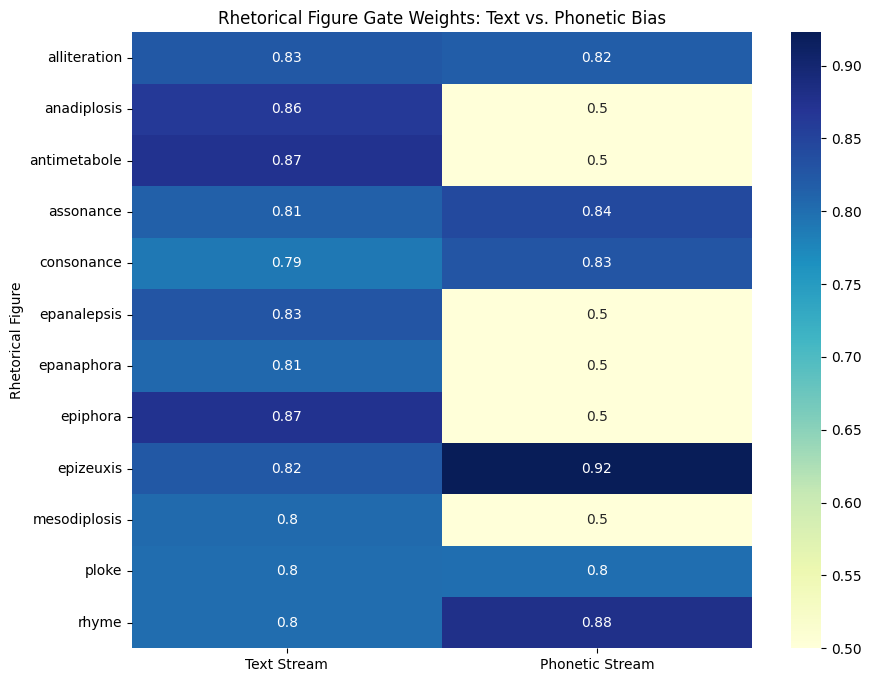

In [48]:
def plot_gate_weights(model, class_names):
    # Get the weights and apply sigmoid to see the 0.0 - 1.0 influence
    weights = torch.sigmoid(model.stream_weights).detach().cpu().numpy()
    
    df_weights = pd.DataFrame(weights, columns=['Text Stream', 'Phonetic Stream'], index=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_weights, annot=True, cmap='YlGnBu')
    plt.title('Rhetorical Figure Gate Weights: Text vs. Phonetic Bias')
    plt.ylabel('Rhetorical Figure')
    plt.show()

# Run it!
plot_gate_weights(model, checkpoint['classes'])